In [29]:
!pip install spacy
!python -m spacy download ru_core_news_lg

2021-05-05 16:01:06.408212: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-05-05 16:01:06.408239: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 515.3 MB 7.1 kB/s eta 0:00:01    |█▏                              | 18.9 MB 4.8 MB/s eta 0:01:45     |██████████▎                     | 164.9 MB 2.1 MB/s eta 0:02:44     |████████████▋                   | 203.6 MB 1.6 MB/s eta 0:03:15


✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

import spacy
from pymystem3 import Mystem
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import time

#import emoji

In [29]:
columns = ['comment', 'date_time', 'color','size', 'thumb_up', 'thumb_down', 'prod_eval', 'prod', 'brand']

df = pd.read_json('./input/file_7961415_946967395_295.jl').transpose().reset_index().drop('index', axis=1)
df = df.set_axis(columns, axis = 'columns')

df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,"Сарафан шикарен, сел идеально. Такой лёгкий, с...",2020-07-24T16:52:19.166628728Z,"черный, белый",44,1,0,5,Сарафан,shovSvaro
1,"Отличный сарафан, стал одним из любимых. Очень...",2019-11-22T11:37:12.282151796Z,"синий, белый",48,1,0,5,Сарафан,shovSvaro
2,"Сарафан хорошо сшит, но для меня много синтети...",2019-11-11T10:04:38.841881311Z,"пастельно-розовый, белый",48,1,0,4,Сарафан,shovSvaro
3,Сарафан мне очень понравился. Я просто влюблен...,2019-09-24T16:53:27.302528222Z,"пастельно-розовый, белый",48,2,0,5,Сарафан,shovSvaro
4,"Не понравилось как село , на фигуру груша боль...",2019-09-05T10:58:25.577249481Z,"пастельно-розовый, белый",46,2,0,5,Сарафан,shovSvaro


# Stopwords extension

In [30]:
# нужно обновить стоп-слова, добавив как миниму то, что в облаке. Сейчас использую стоп-слова NLTK, 
# но стоит сравнить с другими
russian_stopwords = stopwords.words("russian")

russian_stopwords.extend(['очень', 'хороший', 'отличный', 'свой', 'отзыв', 'миксер', 'супер','это', 'спасибо', 'работа',
                          re.sub(r'[.,?!@#~`$%^&*_+-=]', '', df['brand'][0].lower()), 
                          re.sub(r'[.,?!@#~`$%^&*_+-=]', '', df['prod'][0].lower())])
#print(len(russian_stopwords))
#print(len(russian_stopwords))

In [42]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment
0,"Сарафан шикарен, сел идеально. Такой лёгкий, с...",2020-07-24T16:52:19.166628728Z,"черный, белый",44,1,0,5,Сарафан,shovSvaro,шикарен сел идеально лёгкий струящийся стройни...,шикарный садиться идеально легкий струиться ст...
1,"Отличный сарафан, стал одним из любимых. Очень...",2019-11-22T11:37:12.282151796Z,"синий, белый",48,1,0,5,Сарафан,shovSvaro,сарафан стал одним любимых удобный стройнит пр...,сарафан становиться один любимый удобный строй...
2,"Сарафан хорошо сшит, но для меня много синтети...",2019-11-11T10:04:38.841881311Z,"пастельно-розовый, белый",48,1,0,4,Сарафан,shovSvaro,сшит синтетики тянется спинка занижена поэтому...,сшивать синтетика тянуться спинка занижать поэ...
3,Сарафан мне очень понравился. Я просто влюблен...,2019-09-24T16:53:27.302528222Z,"пастельно-розовый, белый",48,2,0,5,Сарафан,shovSvaro,понравился просто влюблена него сшит отлично п...,понравиться просто влюбленный он сшивать отлич...
4,"Не понравилось как село , на фигуру груша боль...",2019-09-05T10:58:25.577249481Z,"пастельно-розовый, белый",46,2,0,5,Сарафан,shovSvaro,понравилось село фигуру груша подойдёт рекомен...,понравиться село фигура груша подходить рекоме...


# Очистка текста (эмодзи, стоп-слова, символы)

In [32]:
### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

    text = text.translate(string.punctuation)
    text = text.lower().split()
    text = [w for w in text if not w in russian_stopwords and len(w) >= 3]
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[,!.\/'+-=)(]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\%", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\|", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(text.split())
    

    return text


In [33]:
%time
df['cleaned_comment'] = df['comment'].map(lambda x: clean_text(x))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.78 µs


In [34]:
df.head()

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment
0,"Сарафан шикарен, сел идеально. Такой лёгкий, с...",2020-07-24T16:52:19.166628728Z,"черный, белый",44,1,0,5,Сарафан,shovSvaro,шикарен сел идеально лёгкий струящийся стройни...
1,"Отличный сарафан, стал одним из любимых. Очень...",2019-11-22T11:37:12.282151796Z,"синий, белый",48,1,0,5,Сарафан,shovSvaro,сарафан стал одним любимых удобный стройнит пр...
2,"Сарафан хорошо сшит, но для меня много синтети...",2019-11-11T10:04:38.841881311Z,"пастельно-розовый, белый",48,1,0,4,Сарафан,shovSvaro,сшит синтетики тянется спинка занижена поэтому...
3,Сарафан мне очень понравился. Я просто влюблен...,2019-09-24T16:53:27.302528222Z,"пастельно-розовый, белый",48,2,0,5,Сарафан,shovSvaro,понравился просто влюблена него сшит отлично п...
4,"Не понравилось как село , на фигуру груша боль...",2019-09-05T10:58:25.577249481Z,"пастельно-розовый, белый",46,2,0,5,Сарафан,shovSvaro,понравилось село фигуру груша подойдёт рекомен...


# Mystem и удаление опустевших комментов

In [43]:
df[df['cleaned_comment']=='']

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment


In [44]:
df = df.drop(df[df['cleaned_comment']==''].index)

In [45]:
def lemmatize(text): 
    text =  [i for i in text]
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []
    count = 0
    lemma = m.lemmatize(merged_text)
    for t in lemma:
        
        if t != '|' and count+1<len(lemma):
            doc.append(t)
            count+=1
          
        else:
            doc = ''.join(i for i in doc)
            res.append(doc)
            count+=1
            doc = []
    return res

In [46]:
%time
res = lemmatize(df['cleaned_comment'])

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.78 µs


In [47]:
df['lemma_comment'] = res

In [48]:
%time
df['lemma_comment'] = df['lemma_comment'].map(lambda x: clean_text(x))
df = df.drop(df[df['lemma_comment']==''].index)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.34 µs


In [49]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment
0,"Сарафан шикарен, сел идеально. Такой лёгкий, с...",2020-07-24T16:52:19.166628728Z,"черный, белый",44,1,0,5,Сарафан,shovSvaro,шикарен сел идеально лёгкий струящийся стройни...,шикарный садиться идеально легкий струиться ст...
1,"Отличный сарафан, стал одним из любимых. Очень...",2019-11-22T11:37:12.282151796Z,"синий, белый",48,1,0,5,Сарафан,shovSvaro,сарафан стал одним любимых удобный стройнит пр...,становиться любимый удобный стройнит приятный ...
2,"Сарафан хорошо сшит, но для меня много синтети...",2019-11-11T10:04:38.841881311Z,"пастельно-розовый, белый",48,1,0,4,Сарафан,shovSvaro,сшит синтетики тянется спинка занижена поэтому...,сшивать синтетика тянуться спинка занижать поэ...
3,Сарафан мне очень понравился. Я просто влюблен...,2019-09-24T16:53:27.302528222Z,"пастельно-розовый, белый",48,2,0,5,Сарафан,shovSvaro,понравился просто влюблена него сшит отлично п...,понравиться просто влюбленный сшивать отлично ...
4,"Не понравилось как село , на фигуру груша боль...",2019-09-05T10:58:25.577249481Z,"пастельно-розовый, белый",46,2,0,5,Сарафан,shovSvaro,понравилось село фигуру груша подойдёт рекомен...,понравиться село фигура груша подходить рекоме...


In [50]:
df = df.reset_index(drop = True)

In [55]:
preprocessed_comments = df['lemma_comment']
preprocessed_comments

0     шикарный садиться идеально легкий струиться ст...
1     становиться любимый удобный стройнит приятный ...
2     сшивать синтетика тянуться спинка занижать поэ...
3     понравиться просто влюбленный сшивать отлично ...
4     понравиться село фигура груша подходить рекоме...
5     ткань приятный идти фигура шов ровный качестве...
6        платье легкий воздушный село фигура советовать
7     платье легкий струиться материал подбирать бюс...
8     платье красивый нежный одевать влюбляться перв...
9     описание указывать хлопок состав факт вискоза ...
10    короткий редко носить понравиться фасон цвет н...
11                      приятный ткань прекрасно сидеть
12    крутой легкий жара ткань приятный сильно мятьс...
13    замечательный платье ткань стрейч поэтому одев...
14    поддерживать положительный струиться легкий ст...
15    красивый ткань легкий струиться размер размер ...
16    понравиться маленький оказываться маленький гр...
17    легкий тонкий оказываться мало грудь заказ

# Word cloud

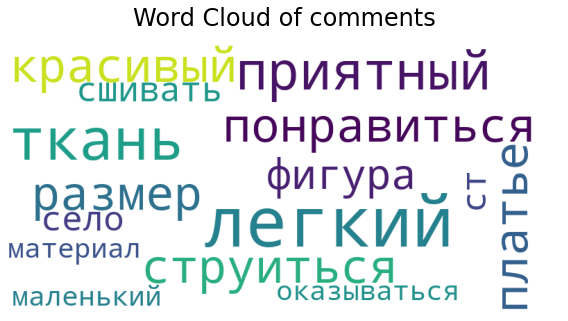

In [52]:
def plot_wordcloud(preprocessed_comments, mask=None, max_words=15, max_font_size=100, figure_size=(8.0,8.0), 
                   title = None, title_size=24, image_color=False):
    stopwords = {}
    wordcloud = WordCloud(background_color='white',
                    mask=None,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 666,
                    contour_width=1,
                    contour_color='black',
                    width=800, 
                    height=400,
                    )
    wordcloud.generate(str(preprocessed_comments))
    fig, ax = plt.subplots(figsize=figure_size)
 #   plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    plt.savefig('/home/sv/Dev/Dev_bootcamp/plot.jpg')
plot_wordcloud(preprocessed_comments, title="Word Cloud of comments")


# tf-idf

In [60]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2))
vectorizer 

TfidfVectorizer(min_df=5, ngram_range=(1, 2))

In [61]:
vectorized_comments = vectorizer.fit_transform(preprocessed_comments)

In [62]:
#  creating a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [66]:
#Эти слова показываем пользователю, он вводит то, по чему хочет почитать подробнее, или свое слово
res=pd.DataFrame(tfidf.sort_values(by=['tfidf'], ascending=True).head(5))

In [81]:
', '.join(res.index)

'легкий, ткань, приятный, размер, фигура'

# Looking for most similar comments for each word

In [30]:
nlp = spacy.load('ru_core_news_lg')

In [31]:
def top_10_similar(word_for_checking, dataframe):
    critical_similarity_value = 0.47
    
    word_for_checking = nlp(word_for_checking)
    similarities = []
    for i in range(len(dataframe['lemma_comment'])):
        similarities.append(nlp(dataframe['lemma_comment'][i]).similarity(word_for_checking))
    
    df_temp = dataframe.copy()
    
    df_temp[f'similarity_to_{word_for_checking}'] = similarities
    #сортировка по убыванию similarities, фильтрация в соответствии с critical_similarity_value
    df_temp = df_temp.sort_values(by = f'similarity_to_{word_for_checking}', ascending = False).head(10)
    res = df_temp[df_temp[f'similarity_to_{word_for_checking}'] > critical_similarity_value][['comment', f'similarity_to_{word_for_checking}']]
    res = list(res['comment'])
    
    if len(res)>0:
        return res
    else: 
        return "По вашему запросу совпадений не найдено"

In [40]:
top_10_similar('скорость', df)

<ipython-input-31-140f86de7d42>:7: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarities.append(nlp(dataframe['lemma_comment'][i]).similarity(word_for_checking))


['Работает, на max скорости не громче, чем хороший миксер.',
 'Суупер. По такой цене мощности хватает. Большая удобная шумит сильно только на последней скорости. Я очень довольна миксером, и магазином.',
 'Миксер просто бомба! Пришёл в двойной упаковке, всё в наличии: инструкция, венчики, лопатка. Цвет фиолетовый хамелеон. Для стационарника достаточно тихо работает, скорости переключаются плавно, на 6 скорости начинается вибрация, но это 4000 оборотов в минуту. Взбивает и смешивает на ура.',
 'Мнё очень понравился...Но прошло два месяца и он сломался..Переключаю первую скорость,очень быстро крутит пять секунд и встаёт...Другие скорости не включаются..Реверс так же ..Покрутит и встаёт..Очень жаль..Миксер то красивый и мощный😔😔😔Жду одобрения по браку через ЛК..Быстрее купить другой..Без миксера как без рук😥',
 'Достаточно мощный аппарат.Качество сборки на высоте.',
 'Это моя первая покупка на Вайлдберриз! И я очень ею довольна .  Скорость отличная  . Запаха пластика нет \nПосмотрим в раб

In [19]:
# пока не работает с неизвестными словами, например, "маломерит"
# если пишешь плохое качество, то выдача вроде та же, что и на хорошее
# вся работа у меня заняла 30 секунд